In [1]:
import os
import json

import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import ContrastiveWrapper

from pytorch_lightning import Trainer

from utils.cp_finder import find_local_maximum_indices

plt.rcParams['figure.figsize'] = [16, 4]

In [51]:
# cp_p = "_harth_cp_seg/_harth_clr_cpmodel/clr_HARTH_0_4_40_1_bs128_lr0.001_l10.0001_l21e-05_cnn_ts10_cnn_ts_dec0_0_decay0.0/version_0/checkpoints/epoch=8-step=27063-val_re=0.0000.ckpt"
cp_p = "_harth_clr_tests/clr_HARTH_21-20-19-18-17_4_40_1_bs128_lr0.001_l10.0001_l21e-05_cnn_gap_ts32_cnn_ts_dec0_0_decay0.0/version_0/checkpoints/epoch=5-step=15252-val_re=0.0000.ckpt"
model = ContrastiveWrapper.load_from_checkpoint(
    checkpoint_path=cp_p)
model.eval()
model.overlap = 0

with open(
    os.path.join(
        os.path.dirname(
            os.path.dirname(
                os.path.dirname(
                    cp_p))), "results.json")
) as f:
    results_loaded = json.load(f)

Input shape:  torch.Size([1, 6, 40])
Latent shape:  torch.Size([1, 128])


In [79]:
class Empty:
    '''Nothing'''

args = Empty()
args.__dict__.update(results_loaded["args"])
args.window_size = 30

dm = load_dm(args)
true_cl = dm.stsds.SCS[dm.stsds.indices[dm.ds_test.indices]]

Loaded dataset HARTH with a total of 6237147 observations for window size 30
Sampling 329096 (balanced) observations per epoch.
Using 3952395 observations for training, 1221736 for validation and 927489 for test


In [80]:
tr = Trainer(accelerator="cpu")
tr.test(datamodule=dm, model=model)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/martin/miniconda3/envs/dev/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Testing DataLoader 0: 100%|██████████| 7247/7247 [00:35<00:00, 206.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap           0.060739483684301376
       test_auroc            0.746781051158905
       test_fpr95           0.7332558631896973
        test_loss                   0.0
         test_th            -0.9995890259742737
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0,
  'test_fpr95': 0.7332558631896973,
  'test_th': -0.9995890259742737,
  'test_auroc': 0.746781051158905,
  'test_ap': 0.060739483684301376}]

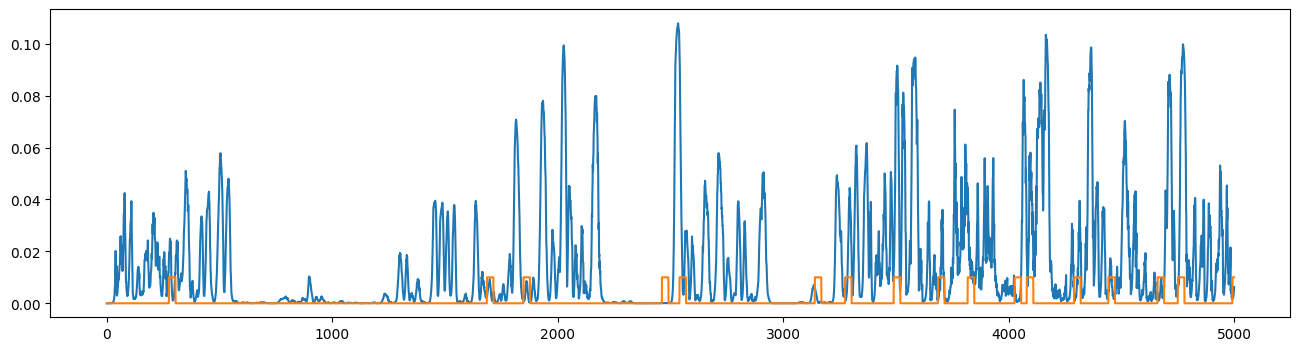

In [81]:
wsize = 30
ovlp = -0
N = 5000

diff = (model.rpr[:(-wsize+ovlp), :] * model.rpr[(wsize-ovlp):, :]).sum(-1)

kernel = 0.7 ** np.arange(40, 0, -1) # similar to uniform mean
kernel = kernel / np.sum(kernel)
diff = -diff+1
diff = np.convolve(diff.numpy(), kernel, mode="full")[:-39]

plt.plot(np.arange(N), diff[:N], np.arange(N), 0.01*model.labels_[:N])

In [74]:
cp_indices = find_local_maximum_indices(diff[:N], 0.01, 1, 1, 1)
cp_plot = np.zeros(N)
cp_plot[np.array(cp_indices)] = 1

j=0
while j<len(cp_indices)-1:
    if cp_indices[j+1]-cp_indices[j]<16:
        new_id = int((cp_indices.pop(j) + cp_indices.pop(j))/2)
        cp_indices.insert(j, new_id)
    j+=1

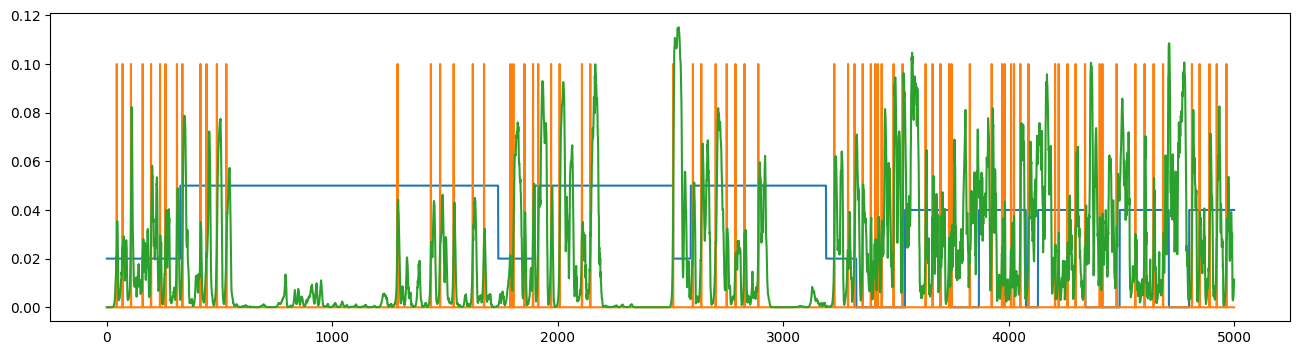

In [76]:
plt.plot(np.arange(N), 0.01*true_cl[:N], np.arange(N), 0.1*cp_plot, np.arange(N), diff[:N])